# Headstart IMDB reviews sentiment analysis project

In this project the aim is to build a machine learning model able to classify movie reviews into *positive* or *negative*, extracting information from the text of the review. This task is called **Sentiment Analysis**, where you need to identify the sentiment of a text.

We downloaded the data from [Kaggle](https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews), however, the original data is available [here](http://ai.stanford.edu/~amaas/data/sentiment/). You **do not** need to download this data, we have already downloaded this data below for you in the correct training, validation and test splits.

You are given the data split into:
- training data: 30,000 reviews annotated with *positive* and *negative* labels;
- validation data: 10,000 reviews annotated with *positive* and *negative* labels;
- test data: 10,000 reviews un-labelled for which you should predict labels for (you will submit your predictions for this test data to the competition server). 

Your challenge is to write a program to guess whether each review is labelled as positive or negative. 

For humans it is quite easy to do. For example one review starts: "i can't believe how dumb this movie truly is." which we would rightly assign as being a negative review, but can we program a computer to guess?

We could hardcode a lot of rules (e.g. does it contain "dumb", "boring" vs "good", "superb") and that is one approach that might work in some simple domains, but we are interested here in learning from data ("machine learning"). This is what the 30,000 training examples and 10,000 validation examples are for. You should use these to train (and validate) a machine learning classifier to decide for each string whether it is a *positive* or *negative* review.

We have a competition server set up on [Codalab](https://competitions.codalab.org/competitions/25363#participate-submit_results) which knows the true labels for these reviews. You will need to [create an account](https://competitions.codalab.org/accounts/signup/) on CodaLab then upload your predictions. These are in the form of a zipped textfile (each row says 'positive' or 'negative'). We have tried to make this easier by providing the ```create_zip``` function below. This generates the answer.zip file with your predictions. You will them be able to submit this file into the Codalab website and we will create a leaderboard with all answers. You can submit as many entries as you want, but me mindful that your user/team name is going to appear in the leaderboard!

We hope you enjoy the challenge!

## Modules, Functions and Downloads

The following few cells import useful modules, download the datasets and provide a series of useful functions. Feel free to run these without needing to read through them.

In [18]:
##These are some python libraries that will be useful for your project
#(feel free to just run this cell & move on)
import numpy as np
import urllib.request
from urllib.request import urlopen
import re
from zipfile import ZipFile
from google.colab import files
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

#classifiers from sklearn. More options here: https://scikit-learn.org/stable/supervised_learning.html#supervised-learning
from sklearn.linear_model import LogisticRegression #Logistic regression classifier: https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
from sklearn.neighbors import KNeighborsClassifier #K-neareast neighbors classifier: https://scikit-learn.org/stable/modules/neighbors.html#nearest-neighbors-classification
from sklearn.dummy import DummyClassifier #Dummy classifier (majority class): https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html
from sklearn.naive_bayes import GaussianNB #Naive Bayes classifier: https://scikit-learn.org/stable/modules/naive_bayes.html#gaussian-naive-bayes
from sklearn.tree import DecisionTreeClassifier #Decision tree classifier: https://scikit-learn.org/stable/modules/tree.html#classification
from sklearn.ensemble import RandomForestClassifier #Random Forests classifier: https://scikit-learn.org/stable/modules/ensemble.html#forests-of-randomized-trees
from sklearn.neural_network import MLPClassifier #Multi-layer perceptron classifier: https://scikit-learn.org/stable/modules/neural_networks_supervised.html#classification

#pre-processing and feature extraction
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#evaluation
from sklearn.metrics import accuracy_score, confusion_matrix

This cell just loads the data in the correct splits for our challenge. You should not change this part!

In [19]:
### DO NOT change this part ###

#loading datasets
df_test = pd.read_csv('https://github.com/carolscarton/headstart/raw/master/data/hs2020_imdb_test.csv')
df_val = pd.read_csv('https://github.com/carolscarton/headstart/raw/master/data/hs2020_imdb_val.csv')
df_train = pd.read_csv('https://github.com/carolscarton/headstart/raw/master/data/hs2020_imdb_train.csv')

Pre-processing function (same as in the practical session).

In [20]:
########### PRE-PROCESSING ###########
#Pre-processing the reviews
#normalise words, remove punctuation, remove extra spaces, etc
def pre_proc(features):
    processed_features = []
    for sentence in range(0, len(features)):
        # Remove all tags (like <br />)
        processed_feature = re.sub(r'<.*?>', ' ', str(features[sentence]))

        #Remove all special characters
        processed_feature = re.sub(r'[^a-zA-Z0-9]', ' ', processed_feature)

        # Substituting multiple spaces with single space
        processed_feature = re.sub(r'\s+', ' ', processed_feature, flags=re.I)

        # Removing prefixed 'b'
        processed_feature = re.sub(r'^b\s+', '', processed_feature)
        
        # Removing everything that has numbers 
        processed_feature = re.sub(r'\w*\d\w*', '', processed_feature)

        # Converting to Lowercase
        processed_feature = processed_feature.lower()

        processed_features.append(processed_feature)
    return processed_features


Feature extraction function (same as in the practical session).

In [21]:
########### EXTRACT FEATURES ###########
# We will use bag-of-words as features for training our classifiers. 
# In a bag-of-words approach, an algorithm counts the number of times a word appear in a document. 
# Each word in the entire collection of documents (corpus) became a feature in the feature vector, which results in a sparse vector.
# Instead of count the "number of times" a word appear in a document, we can also use a binary approach (whether or not a word a appear in a document). 
# By default, we are using a binary bag-of-words approach: 
# if a word appears in a document it will receive 1 (0 otherwise)
# you can change all these parameters below
def extract_features(proc_train, proc_val, proc_test, binary=False, max_df=1.0, min_df=0.0, ngram_range=(1,1), sw=False):
    stop_words=[]
    if sw:
        f = urlopen("https://raw.githubusercontent.com/lionfish0/discover_stem/master/stopwords.txt").read()
        stop_words = list(np.array(f.split(), dtype=str))

    cv = CountVectorizer(binary=True, max_df=max_df, min_df=min_df, ngram_range=ngram_range, stop_words=stop_words)
    cv.fit(proc_train)

    #check the features outputted below
    #each possible word in our pre-processed vector became a feature
    #can we do better? 
    print("** Vocabulary size: %d" % len(cv.get_feature_names()))
    print("** Words:")
    #print(cv.get_feature_names())

    #apply the model to all data splits
    #can you think of any problems? 
    X_train = cv.transform(proc_train)
    X_val = cv.transform(proc_val)
    X_test = cv.transform(proc_test)
    return X_train, X_val, X_test



Evaluation function (same as in the practical session).


In [22]:
########### EVALUATION ###########
#just a function to print a nice confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() * 0.8
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                      color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
class_names = ['0', '1', '2', '3', '4']
np.set_printoptions(precision=2)

#evaluation function
def evaluate_classifier(y_test, y_pred):
    print("*** Accuracy score: %.4f\n" % accuracy_score(y_test, y_pred))
    ax = plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
    plt.plot()


Code to create a .zip file for the predictions (answers) of our classifier. Please, see below how to download this file and how to upload it in the Codalab competition.

In [23]:
########### CREATE ZIP FILE FOR CODALAB ###########
#builds and lets you download the answer.zip file
def create_zip (answers):
  from zipfile import ZipFile
  answertext = '\n'.join(answers)
  with open('answer.txt', 'w') as filehandle:
      filehandle.write(answertext)
  with ZipFile('answer.zip', 'w') as zipf:
      zipf.write('answer.txt')    

### only works in Chrome (apparently)
  from google.colab import files
  files.download('answer.zip') 

<hr>

# The Data

To give you an idea of the dataset, we print the validation set with the labels (i.e. if positive or negative). Below, we also print the test set that does not contain labels.

In [24]:
print(df_val)

                                                 review sentiment
0     First off I want to say that I lean liberal on...  negative
1     I was excited to see a sitcom that would hopef...  negative
2     When you look at the cover and read stuff abou...  negative
3     Like many others, I counted on the appearance ...  negative
4     This movie was on t.v the other day, and I did...  negative
...                                                 ...       ...
9995  I thought this movie did a down right good job...  positive
9996  Bad plot, bad dialogue, bad acting, idiotic di...  negative
9997  I am a Catholic taught in parochial elementary...  negative
9998  I'm going to have to disagree with the previou...  negative
9999  No one expects the Star Trek movies to be high...  negative

[10000 rows x 2 columns]


In [25]:
print(df_test)

                                                 review
0     One of the other reviewers has mentioned that ...
1     A wonderful little production. <br /><br />The...
2     I thought this was a wonderful way to spend ti...
3     Basically there's a family where a little boy ...
4     Petter Mattei's "Love in the Time of Money" is...
...                                                 ...
9995  Fun, entertaining movie about WWII German spy ...
9996  Give me a break. How can anyone say that this ...
9997  This movie is a bad movie. But after watching ...
9998  This is a movie that was probably made to ente...
9999  Smashing film about film-making. Shows the int...

[10000 rows x 1 columns]


# Example Classifier 1

In this example we assign *positive* and *negative*, e.g. `['positive','positive','negative','positive','negative'...]`.  This list is based in the size of the review (so, a very naive solution).

*** Accuracy score: 0.5684



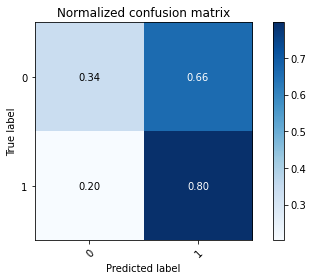

In [26]:
#in this very simple classifier we just test if one of five 'positive' words are in the review.
#please note that we are using the validation set here (since we can evaluate using it!)
naive_classifier = []
for t in df_val['review']:
  if np.any([substr in t.lower() for substr in ['best','wonderful','good','favourite','great','fun','family']]):
    naive_classifier.append('positive')
  else:
    naive_classifier.append('negative')

#we can evaluate how good this approach is (using the validation set)
evaluate_classifier(df_val['sentiment'], naive_classifier)

#uncomment to generate answers for test data for submission to codalab using this classifier.
naive_classifier_on_test = []
for t in df_test['review']:
  if np.any([substr in t.lower() for substr in ['best','wonderful','good','favourite','great']]):
    naive_classifier_on_test.append('positive')
  else:
    naive_classifier_on_test.append('negative')
#create_zip(naive_classifier_on_test)

# Example Classifier 2

Similar to our practical session, you have available the functions for data pre-processing and feature extraction.

Below there is an example on how to run them and how to train a sklearn classifier. 


In [27]:
# apply pre_proc() function to all data splits
proc_train = pre_proc(df_train['review'])
proc_val = pre_proc(df_val['review'])
proc_test = pre_proc(df_test['review'])

# call extract_features() to extract features
# you can play with the parameters of this function do generate different feature vectors:
### binary = True --> means that it will create a binary vector (either a word appears in a review or not)
###          changing it to False will use frequencies (how many times a word appears in a review)
###          it will also normalise it. 
### max_df = ignore terms that have a frequency higher than the value assigned (1.0 means no term is discarded)
### min_df = ignore terms that have a frequency lower than the value assigned (0.0 means no term is discarded)
### ngram_range = range of the n_grams. If (1,1) only single words are considered. If (1,2) single words and 2-word groups are considered
###               If (1,3) single words, 2-word, and 3-word groups are considered. Be careful because this can create far too many positions in your vector!
### sw = if True, it will use a pre-defined stopwords list to filter out some terms.  
X_train, X_val, X_test = extract_features(proc_train, proc_val, proc_test, binary=True, max_df=10.0, min_df=0.0, ngram_range=(1,1), sw=False)

# extract labels
y_train = df_train['sentiment']
y_val = df_val['sentiment']
y_test = df_val['sentiment']

** Vocabulary size: 80566
** Words:


In [28]:
# example of a sklearn classifier (you can try with other examples from the practical session)
# in the first code block here we also import several others classifiers available in sklearn
# they all follow the same structure:
## 1-) create an instance of the classifier (e.g. kkn = NeighborsClassifier())
## 2-) train the model using the training data (e.g. knn.fit(X_train, y_train))
## 3-) generate predictions for the test set (e.g. preds = knn.predict(X_test))
## more information about sklearn classifiers: https://scikit-learn.org/stable/supervised_learning.html
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
knn_preds_val = knn.predict(X_val)

Predicted values for the validation set:
['negative' 'negative' 'negative' ... 'negative' 'negative' 'negative']
*** Accuracy score: 0.6118

0       negative
1       negative
2       negative
3       negative
4       negative
          ...   
9995    positive
9996    negative
9997    negative
9998    negative
9999    negative
Name: sentiment, Length: 10000, dtype: object


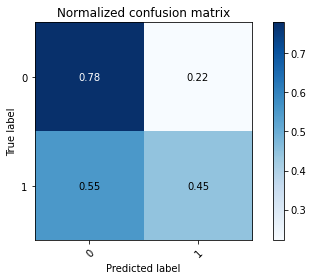

In [29]:
# evaluating the model in the validation set (you do not have gold values for test set here!)
print("Predicted values for the validation set:")
print(knn_preds_val)
evaluate_classifier(y_val, knn_preds_val)
print(y_val)

In [30]:
# predicting the test set
#we can't assess how well these have done in this notebook for that we
#will have to submit them to the codalab competition system (see below)
knn_preds_test = knn.predict(X_test)

print("Predicted values for the test set:")
print(knn_preds_test)

Predicted values for the test set:
['negative' 'positive' 'positive' ... 'negative' 'negative' 'negative']


# Save predictions

You next need to submit these 10,000 predictions to the Codalab competition. To do that we need to save these predictions to a file and then [upload it to the competition server](https://competitions.codalab.org/competitions/25363#participate-submit_results). On that page click on 'Submit' to upload the ```answer.zip``` file. You will need an account on codalab to submit your results ([sign up](https://competitions.codalab.org/accounts/signup/)).

We have written a function, ```create_zip```, to create this file. In particular,
- The file uploaded is called ```answer.zip``` and contains one file called ```answer.txt```.
- ```answer.txt``` contains one prediction per line (either 'positive' or 'negative').

When you run the ```create_zip()``` function, it should ask you to download the file to your computer. If this doesn't work you will need to download it via the colab files interface (see end of notebook for more details).

Please note that:
1.   the submission system only works with the format that we have described above. If you are using another machine learning technique that does not output a list of 'positive' or 'negative' lines you will need to write code to convert to this format.

2.   Every time you run the ```create_zip()``` function you will overwrite any other ```answer.zip``` file that you have in this colab environment. Please save any different files in your local computer and keep control of your different versions (see below how to download the .zip file to your computer).


In [31]:
#Convert the 'knn_preds_test' array of 'negative' and
#'positive's into an answer.zip file. This will also
#try to allow you to download the file. 
create_zip(knn_preds_test)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Your Classifier

You need to write your own classifier here!

** Vocabulary size: 5846668
** Words:
Accuracy for C=0.07: 0.8777
Accuracy for C=0.08: 0.8777
Accuracy for C=0.09: 0.8779
Accuracy for C=0.1: 0.8777
Accuracy for C=0.11: 0.8781
Accuracy for C=0.17: 0.879
*** Best accuracy = 0.879000, best C = 0.170000
*** Accuracy score: 0.8790



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

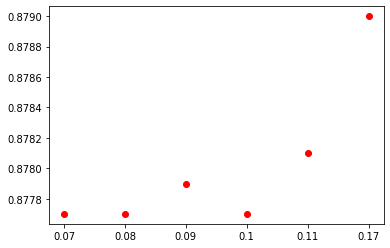

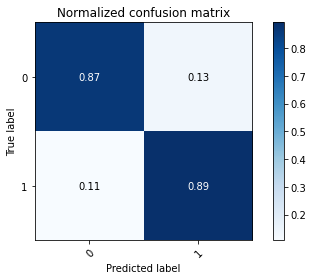

In [32]:

############################## preparing data

# apply pre_proc() function to all data splits
proc_train = pre_proc(df_train['review'])
proc_val = pre_proc(df_val['review'])
proc_test = pre_proc(df_test['review'])

#extract features
X_train, X_val, X_test = extract_features(proc_train, proc_val, proc_test, binary=False, max_df=10.0, min_df=0.0, ngram_range=(1,2), sw=False)

# extract pre-known sentiment labels (used for training and evaluation)
y_train = df_train['sentiment']
y_val = df_val['sentiment']

############################ finds best parameter c for the logistic regression (based on evaluation set)

def optimise_C(X_train, y_train, X_val, y_val, C=[0.01, 0.025, 0.05, 0.25, 0.5, 1.0]):
    #optimise the parameter C using the validation data
    best_acc = 0.
    best_c = 0.
    accuracies = []
    for c in C:
    
        lr = LogisticRegression(C=c, multi_class='auto', solver='liblinear')
        lr.fit(X_train, y_train)
        cur_acc = accuracy_score(y_val, lr.predict(X_val))
        print ("Accuracy for C=%s: %s" % (c, cur_acc))
        accuracies.append(cur_acc)
        if cur_acc > best_acc:
            best_c = c
            best_acc = cur_acc

    print ("*** Best accuracy = %f, best C = %f" % (best_acc, best_c))
    plt.plot(np.array(C).astype('str'), accuracies, 'ro')
    return best_c

#apply the above function
ngram11_C=[0.0745, 0.075, 0.07525, 0.0754, 0.0755, 0.08, 0.09, 0.10, 0.25] #best c values for ngram_range 1,1
ngram12_C=[0.07,0.08,0.09, 0.10, 0.11,0.17] #best c values for ngram_range 1,2
ngram13_C=[0.3,0.325,0.35,0.375,0.4] #best c values for ngram_range 1,3
best_c = optimise_C(X_train, y_train, X_val, y_val, C=[0.07,0.08,0.09, 0.10, 0.11,0.17])

################################# validation set evaluation

lr = LogisticRegression(C=best_c, multi_class='auto', solver='liblinear')
lr.fit(X_train, y_train) #fits model according to training data
lr_preds = lr.predict(X_val) #predict class labels 
evaluate_classifier(y_val, lr_preds)

################################# test set predictions

lrt = LogisticRegression(C=best_c,multi_class='auto', solver='liblinear')
lrt.fit(X_train,y_train)
lrt_preds=lrt.predict(X_test)

################################create zip
create_zip(lrt_preds)


# Saving the Zip file in your computer

Hopefully the ```create_zip()``` function let you download the ```answer.zip``` file. If it didn't you will need to download the file using the colab interface. On the left hand side of this colab environment, you should see a icon tha looks like a folder (![files](https://github.com/carolscarton/headstart/raw/master/figures/folder.png)). By clicking on it you should see the file structure below (or something similar):

![alt text](https://github.com/carolscarton/headstart/raw/master/figures/file_structure.png)

You should then pass the mouse on top of the file "answer.zip" and click in the menu that appears in the right hand side. The first option is to download the file to your computer:

![alt text](https://github.com/carolscarton/headstart/raw/master/figures/download.png)

